# Deflection of a heavy hyperelastic beam 

In this notebook we give an example for the solution of a problem of nonlinear elasticity

We focus on the simple problem of a cantilever beam loaded only by its own weigth

We exploit `UFL` features for automatic symbolic differentiation and formulate the porblme by writing the potential energy of the system. 

You can use this example in conjuction with the `FEniCS` demo on hypelasticity 
https://fenicsproject.org/docs/dolfin/2018.1.0/python/demos/hyperelasticity/demo_hyperelasticity.py.html
to solve more complex problems including bifurcations and instability for your project.

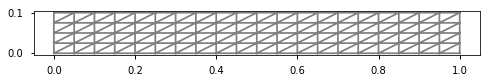

In [64]:
from dolfin import *
#from mshr import *
import numpy as np
import matplotlib.pyplot as plt
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
%matplotlib inline
plt.style.use('seaborn-notebook')
# Create mesh and define boundaries fof BCs
Lx, Ly = 1., .1
mesh = RectangleMesh(Point(0,0),Point(Lx,Ly),20,4)
n = mesh.geometry().dim() # number of space dimensions
plot(mesh)
# Mark boundary subdomians
left = CompiledSubDomain("near(x[0],0) && on_boundary")
right = CompiledSubDomain("near(x[0],Lx) && on_boundary", Lx=Lx)
bottom = CompiledSubDomain("near(x[1],0) && on_boundary")
# Mark facets for Neuman BCs
boundary_markers = MeshFunction("size_t", mesh,1,0)
left.mark(boundary_markers, 1)
right.mark(boundary_markers, 2)
# Redefine element of area to include informations about surface tension
ds = ds(domain=mesh,subdomain_data=boundary_markers)

In [65]:
# Elasticity parameters
E, nu = 1.e6, 0.3
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) # This is to put plane-stress moduli

In [66]:
V_element = VectorElement('CG',triangle, 1) 
scalar_element = FiniteElement('CG',triangle, 1) 
V = FunctionSpace(mesh, V_element)
V_scalar = FunctionSpace(mesh, scalar_element)

In [67]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

# Kinematics
I = Identity(n)    # Identity tensor
F = variable(I + grad(u))             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 2) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# External loads
B = Expression(("0.0", "t"),t=0,degree=0)  
T = E*Constant((0.0, 0)) 

# Total potential energy
PotentialEnergy = psi*dx - dot(B, u)*dx - dot(T, u)*ds(2)

# Compute first variation of Pi (directional derivative about u in the direction of v)
dE = derivative(PotentialEnergy, u, v)

# Compute Jacobian of the energy
ddE = derivative(dE, u, du)

# First Piola-Kirchhoff stress
S = diff(psi, F) 
n = FacetNormal(mesh) # normal to the mesh

In [71]:
# # Save solution in VTK format
file_u = File("results/beam.pvd");

bcl = DirichletBC(V, (0.,0.), left)
bcs = [bcl]

# Set the variational problemb
problem = NonlinearVariationalProblem(dE, u, bcs=bcs, J=ddE)
solver = NonlinearVariationalSolver(problem)

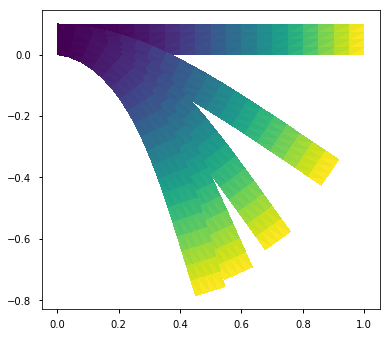

In [72]:
for (i,t) in enumerate(loads):
    B.t = -t*mu
    solver.solve()
    file_u << (u,t)
    plt.figure(1)
    plot(u, mode = "displacement")

# The code below can contains useful hints to solve the buckling problems, but it is not necessary for the case of the heavy beam


B/mu==0.00, u=-0.00
B/mu==0.01, u=-0.43
B/mu==0.03, u=-0.66
B/mu==0.04, u=-0.76
B/mu==0.05, u=-0.82


Text(0,0.5,'displacement')

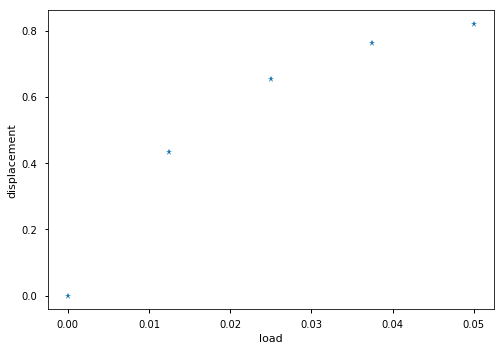

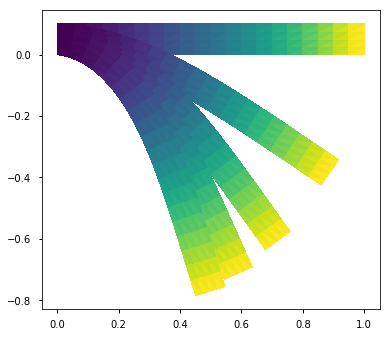

In [73]:

# Set the nonlinear solver
solver = NonlinearVariationalSolver(problem)
solver.parameters["nonlinear_solver"] = "newton"
newtonpar = solver.parameters["newton_solver"]
newtonpar["relaxation_parameter"] = 1.
newtonpar["maximum_iterations"] = 20
newtonpar["absolute_tolerance"] = 1.e-7
info(solver.parameters,True)

I = Ly**3/12.
F_buckling = pi**2*E*I/Lx**2
u_buckling = F_buckling/(E*Ly)
loads = np.linspace(0,0.05, 5)
forces = 0.*loads
displ = 0.*loads
u.rename("u","u")
perturbation = interpolate(Expression(("0","t*x[0]*(L-x[0])"),L=Lx,t=1e-3,degree=2),V)
u.assign(perturbation)
ALE.move(mesh,perturbation)
for (i,t) in enumerate(loads):
    B.t = -t*mu
    #u.assign(u+perturbation)
    solver.solve()
    displ[i] = assemble(u[1]*ds(2))/Ly # average transverse displacement on the rigth end
    print("B/mu==%2.2f, u=%2.2f"%(t,displ[i]))
    # if i in [0,len(loads)/2,len(loads)-1]: plot(u, mode = "displacement")
    file_u << (u,t)
    plt.figure(1)
    plot(u, mode = "displacement")

plt.figure(0)
plt.plot(loads,-displ,"*")
plt.xlabel("load")
plt.ylabel("displacement")